### Enter Fred API key here to run notebook:

In [ ]:
fred_api = ************

In [143]:
import requests
import numpy as np
import pandas as pd
import json

from dateutil.parser import parse

import datetime

import yfinance as yf
from fredapi import Fred 

from bs4 import BeautifulSoup
import re

import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA

import xgboost as xgb
from xgboost import XGBClassifier

import lightgbm as lgbm
from lightgbm import LGBMClassifier

fred = Fred(api_key=f'{fred_api}')

In [8]:
all_data = pd.read_csv('all_data_max_daily.csv')
all_data['model_date'] = pd.to_datetime(all_data['model_date'])  # convert to datetime type
all_data = all_data.set_index('model_date')                      # set model_date as index
all_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35191 entries, 1927-12-30 to 2024-05-04
Data columns (total 60 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   AE                    8887 non-null   float64
 1   ASPUS                 22286 non-null  float64
 2   BAMLC0A0CM            9987 non-null   float64
 3   BAMLEMCBPIOAS         9257 non-null   float64
 4   BAMLEMRACRPIASIAOAS   9257 non-null   float64
 5   BAMLH0A0HYM2          9987 non-null   float64
 6   BAMLH0A0HYM2EY        9987 non-null   float64
 7   BAMLHE00EHYIOAS       9622 non-null   float64
 8   CIVPART               27844 non-null  float64
 9   CORESTICKM159SFRBATL  20566 non-null  float64
 10  CPIAUCSL              28205 non-null  float64
 11  CPILFESL              24552 non-null  float64
 12  CSUSHPINSA            17931 non-null  float64
 13  Credit                8887 non-null   float64
 14  DAAA                  15098 non-null  float64
 15  DF

In [10]:
# I want my model on a weekly timeframe so I will use Friday values only
# Remember that in my data collection phase, if a Friday is a holiday it will contain Thursday's observations

friday_data = all_data[all_data.index.day_name()=='Friday']
friday_data

,AE,ASPUS,BAMLC0A0CM,BAMLEMCBPIOAS,BAMLEMRACRPIASIAOAS,BAMLH0A0HYM2,BAMLH0A0HYM2EY,BAMLHE00EHYIOAS,CIVPART,CORESTICKM159SFRBATL,...,PSAVERT,RRPONTSYD,T10YIE,T5YIE,UNRATE,US,Volatility,WALCL,^GSPC,^VIX
model_date,,,,,,,,,,,,,,,,,,,,,
1927-12-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.660000,NaN
1928-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.660000,NaN
1928-01-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.580000,NaN
1928-01-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.480000,NaN
1928-01-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.690001,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-05,-0.447,492300.0,0.92,1.94,1.34,3.18,7.68,3.57,62.7,4.403102,...,3.6,438.319,2.37,2.45,3.8,-0.965,-0.734,7439558.0,5204.339844,16.030001
2024-04-12,-0.596,492300.0,0.92,1.93,1.31,3.25,7.91,3.68,62.7,4.509212,...,3.6,407.322,2.39,2.47,3.8,-1.084,-0.585,7438176.0,5123.410156,17.309999
2024-04-19,-0.297,492300.0,0.94,1.95,1.31,3.37,8.10,3.66,62.7,4.509212,...,3.6,397.234,2.41,2.44,3.8,-0.861,-0.179,7405506.0,4967.229980,18.709999


In [76]:
# To show where DGS2 becomes available
friday_data.loc['1976-05-01':'1976-06-30']['DGS2']

model_date
1976-05-07     NaN
1976-05-14     NaN
1976-05-21     NaN
1976-05-28     NaN
1976-06-04    7.12
1976-06-11    7.03
1976-06-18    6.99
1976-06-25    7.02
Name: DGS2, dtype: float64

In [77]:
# I want to see data from June 1976 

friday_1976=friday_data.loc['1976-06-01':]
friday_1976 = friday_1976.dropna(axis='columns') # drop any columns that start after June 1976
friday_1976.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2501 entries, 1976-06-04 to 2024-05-03
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ASPUS                 2501 non-null   float64
 1   CIVPART               2501 non-null   float64
 2   CORESTICKM159SFRBATL  2501 non-null   float64
 3   CPIAUCSL              2501 non-null   float64
 4   CPILFESL              2501 non-null   float64
 5   CSUSHPINSA            2501 non-null   float64
 6   DFF                   2501 non-null   float64
 7   DGS10                 2501 non-null   float64
 8   DGS2                  2501 non-null   float64
 9   DGS20                 2501 non-null   float64
 10  DGS3                  2501 non-null   float64
 11  DGS5                  2501 non-null   float64
 12  DGS7                  2501 non-null   float64
 13  DTB3                  2501 non-null   float64
 14  GDP                   2501 non-null   float64
 15  GDP

In [102]:
friday_1976.describe()

,ASPUS,CIVPART,CORESTICKM159SFRBATL,CPIAUCSL,CPILFESL,CSUSHPINSA,DFF,DGS10,DGS2,DGS20,...,PAYEMS,PCE,PSAVERT,UNRATE,^GSPC,TermSpread,DGS10_13WShift,^GSPC_13WShift,DGS10_13WChange,^GSPC_13WChange
count,2488.000000,2488.000000,2488.000000,2488.000000,2488.000000,2488.000000,2488.000000,2488.000000,2488.000000,2488.000000,...,2488.000000,2488.000000,2488.000000,2488.000000,2488.000000,2488.000000,2488.000000,2488.000000,2488.000000,2488.000000
mean,222330.988746,64.793408,4.036563,215.948500,176.983014,120.468398,4.639172,5.880145,5.003806,6.138955,...,121159.923633,7341.940233,4.956632,6.134365,1189.732581,0.876338,5.862002,1215.926066,-0.018143,2.347511
std,120097.523802,1.744006,2.620632,58.347302,65.237086,68.045445,4.010582,3.301397,3.742613,3.041927,...,20981.087947,4730.273120,3.444466,1.747309,1132.823112,0.925824,3.300260,1164.925260,0.631761,7.500148
min,46000.000000,60.200000,0.660000,115.900000,56.700000,26.840000,0.040000,0.550000,0.090000,0.980000,...,78988.000000,1066.700000,-1.700000,3.400000,87.449997,-2.340000,0.550000,87.449997,-3.370000,-38.087753
25%,134800.000000,63.200000,2.360000,168.400000,121.900000,68.847500,1.060000,3.087500,1.607500,3.807500,...,104777.750000,3091.300000,3.500000,4.900000,281.307495,0.197500,3.087500,289.662514,-0.350000,-1.519567
50%,202400.000000,65.000000,3.110000,213.522000,179.500000,99.795000,4.695000,5.385000,4.780000,5.890000,...,129755.500000,6596.600000,5.000000,5.800000,1008.535004,0.830000,5.290000,1028.220032,0.000000,2.801236
75%,304200.000000,66.400000,4.880000,254.350500,227.684000,167.330000,6.645000,8.020000,7.282500,7.390000,...,136554.000000,10901.900000,6.600000,7.300000,1465.780029,1.510000,8.020000,1481.917511,0.320000,6.978497
max,542900.000000,67.600000,15.790000,345.900000,313.216000,312.953000,20.610000,15.680000,16.890000,15.530000,...,157700.000000,19001.700000,33.000000,14.700000,4958.609863,2.910000,15.680000,5254.350098,2.560000,37.564755


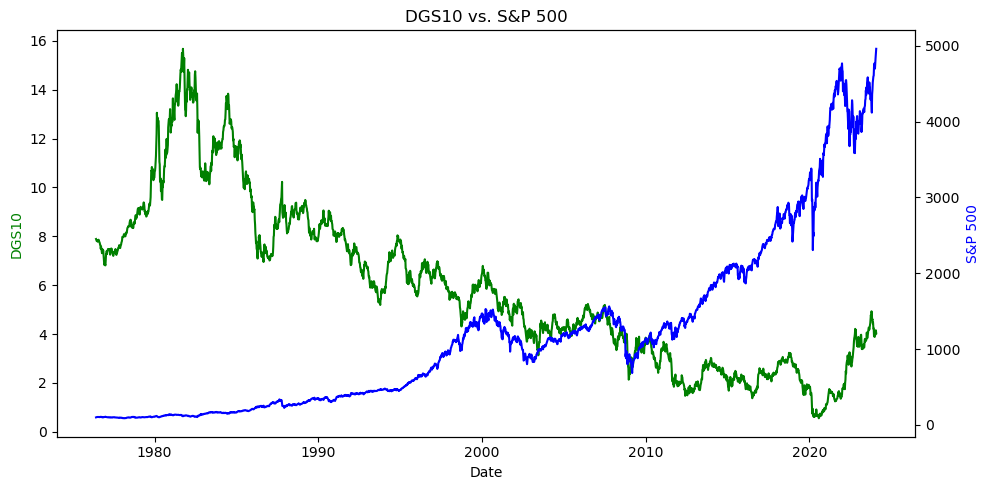

In [116]:
# Compare DGS10 with S&P 500 (GSPC)
# https://www.geeksforgeeks.org/how-to-add-a-y-axis-label-to-the-secondary-y-axis-in-matplotlib/

x = friday_1976.index
y1 = friday_1976['DGS10']
y2 = friday_1976['^GSPC']

fig, ax = plt.subplots(figsize = (10, 5))
plt.title('DGS10 vs. S&P 500')
 
ax2 = ax.twinx()
ax.plot(x, y1, color = 'g')
ax2.plot(x, y2, color = 'b')
 

ax.set_xlabel('Date')
ax.set_ylabel('DGS10', color = 'g')
 
ax2.set_ylabel('S&P 500', color = 'b')
 

plt.tight_layout()
 
plt.show()

In [78]:
# Function to create some new columns, including the 13W (3-month) shift columns

def my_new_features(df):
    
    df['TermSpread'] = df['DGS10'] - df['DGS2'] # new feature I believe may be important

    df['DGS10_13WShift'] = df['DGS10'].shift(-13)
    df['^GSPC_13WShift'] = df['^GSPC'].shift(-13)

    df['DGS10_13WChange'] = df['DGS10_13WShift'] - df['DGS10']
    df['^GSPC_13WChange'] = ( (df['^GSPC_13WShift'] / df['^GSPC']) - 1 ) * 100

In [79]:
my_new_features(friday_1976) # apply function to friday_1976 dataframe
friday_1976 = friday_1976.dropna() # drop rows that don't have a 13WShift value yet (the most recent 13 weeks)
friday_1976.tail()

,ASPUS,CIVPART,CORESTICKM159SFRBATL,CPIAUCSL,CPILFESL,CSUSHPINSA,DFF,DGS10,DGS2,DGS20,...,PAYEMS,PCE,PSAVERT,UNRATE,^GSPC,TermSpread,DGS10_13WShift,^GSPC_13WShift,DGS10_13WChange,^GSPC_13WChange
model_date,,,,,,,,,,,,,,,,,,,,,
2024-01-05,513400.0,62.5,4.730629,307.917,312.251,312.953,5.33,4.05,4.40,4.37,...,157232.0,18858.9,4.1,3.7,4697.240234,-0.35,4.39,5204.339844,0.34,10.795692
2024-01-12,513400.0,62.5,4.584186,308.850,313.216,312.953,5.33,3.96,4.14,4.32,...,157232.0,18858.9,4.1,3.7,4783.830078,-0.18,4.50,5123.410156,0.54,7.098498
2024-01-19,513400.0,62.5,4.584186,308.850,313.216,312.953,5.33,4.15,4.39,4.47,...,157232.0,18858.9,4.1,3.7,4839.810059,-0.24,4.62,4967.229980,0.47,2.632746
2024-01-26,492300.0,62.5,4.584186,308.850,313.216,312.953,5.33,4.15,4.34,4.49,...,157232.0,19001.7,3.7,3.7,4890.970215,-0.19,4.67,5099.959961,0.52,4.272971
2024-02-02,492300.0,62.5,4.584186,308.850,313.216,312.146,5.33,4.03,4.36,4.33,...,157700.0,19001.7,3.7,3.7,4958.609863,-0.33,4.58,5127.790039,0.55,3.411847


In [83]:
# To see some percentile thresholds for the 13-week change in DGS10

friday_1976['DGS10_13WChange'].quantile([0.1,0.15,0.2,0.25,0.5,0.75,0.8,0.85,0.9])

0.10   -0.72
0.15   -0.56
0.20   -0.45
0.25   -0.35
0.50    0.00
0.75    0.32
0.80    0.41
0.85    0.52
0.90    0.67
Name: DGS10_13WChange, dtype: float64

In [84]:
# Create ranges for change in 13-week change in DGS10:

def DGS10_ranges(row):
    if row <= -0.5:
        return '<=-0.5'
    elif -0.5< row < 0.5:
        return 'between -0.5 and 0.5'
    else:
        return '>=0.5'


friday_1976['DGS10_change_range'] = friday_1976['DGS10_13WChange'].apply(DGS10_ranges)
friday_1976.tail()

,ASPUS,CIVPART,CORESTICKM159SFRBATL,CPIAUCSL,CPILFESL,CSUSHPINSA,DFF,DGS10,DGS2,DGS20,...,PCE,PSAVERT,UNRATE,^GSPC,TermSpread,DGS10_13WShift,^GSPC_13WShift,DGS10_13WChange,^GSPC_13WChange,DGS10_change_range
model_date,,,,,,,,,,,,,,,,,,,,,
2024-01-05,513400.0,62.5,4.730629,307.917,312.251,312.953,5.33,4.05,4.40,4.37,...,18858.9,4.1,3.7,4697.240234,-0.35,4.39,5204.339844,0.34,10.795692,between -0.5 and 0.5
2024-01-12,513400.0,62.5,4.584186,308.850,313.216,312.953,5.33,3.96,4.14,4.32,...,18858.9,4.1,3.7,4783.830078,-0.18,4.50,5123.410156,0.54,7.098498,>=0.5
2024-01-19,513400.0,62.5,4.584186,308.850,313.216,312.953,5.33,4.15,4.39,4.47,...,18858.9,4.1,3.7,4839.810059,-0.24,4.62,4967.229980,0.47,2.632746,between -0.5 and 0.5
2024-01-26,492300.0,62.5,4.584186,308.850,313.216,312.953,5.33,4.15,4.34,4.49,...,19001.7,3.7,3.7,4890.970215,-0.19,4.67,5099.959961,0.52,4.272971,>=0.5
2024-02-02,492300.0,62.5,4.584186,308.850,313.216,312.146,5.33,4.03,4.36,4.33,...,19001.7,3.7,3.7,4958.609863,-0.33,4.58,5127.790039,0.55,3.411847,>=0.5


<Axes: xlabel='DGS10_change_range', ylabel='^GSPC_13WChange'>

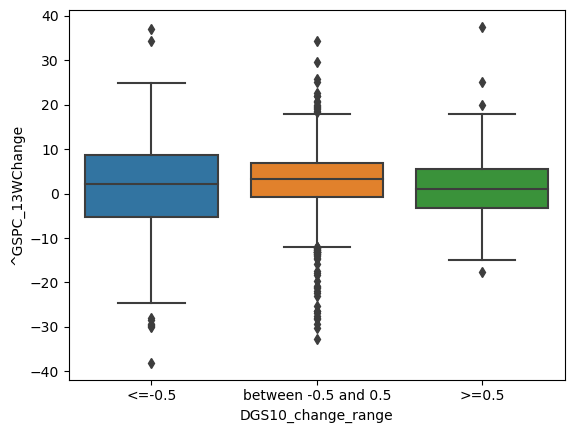

In [103]:
sns.boxplot(x='DGS10_change_range',y='^GSPC_13WChange',data=friday_1976, order=['<=-0.5','between -0.5 and 0.5','>=0.5'])

In [86]:
friday_1976['DGS10_change_range'].value_counts()

between -0.5 and 0.5    1647
<=-0.5                   442
>=0.5                    399
Name: DGS10_change_range, dtype: int64

In [115]:
# To see how the S&P 500 (GSPC) moves coincidentally to changes in DGS10

DGS10_change_comp = friday_1976.groupby('DGS10_change_range')['^GSPC_13WChange'].agg(['mean','std','min','max'])

# Calculate reward-to-risk using annualized average return and annualized volatility
DGS10_change_comp['Reward-to-risk'] = (DGS10_change_comp['mean']*4) / (DGS10_change_comp['std'] * (4**0.5))

DGS10_change_comp

,mean,std,min,max,Reward-to-risk
DGS10_change_range,,,,,
<=-0.5,1.223612,10.407408,-38.087753,37.074540,0.235143
>=0.5,1.511446,6.482001,-17.662084,37.564755,0.466352
between -0.5 and 0.5,2.851672,6.712024,-32.730703,34.396860,0.849720


In [146]:
# Create class column for change in DGS10
# -1 if <=-0.5
# 0 if between -0.5 and 0.5
# 1 if >=0.5

friday_1976['DGS10_change_class'] = [0 if x=='<=-0.5' else 2 if x=='>=0.5' else 1 
                                     for x in friday_1976['DGS10_change_range']]

### There is a clear improvement in the S&P 500's reward-to-risk ratio during times when the change in DGS10 is between -0.5 and 0.5. Therefore, I will use these thresholds as my classes for predicting the 13-week change in DGS10.

In [147]:
friday_1976.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2488 entries, 1976-06-04 to 2024-02-02
Data columns (total 36 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ASPUS                 2488 non-null   float64
 1   CIVPART               2488 non-null   float64
 2   CORESTICKM159SFRBATL  2488 non-null   float64
 3   CPIAUCSL              2488 non-null   float64
 4   CPILFESL              2488 non-null   float64
 5   CSUSHPINSA            2488 non-null   float64
 6   DFF                   2488 non-null   float64
 7   DGS10                 2488 non-null   float64
 8   DGS2                  2488 non-null   float64
 9   DGS20                 2488 non-null   float64
 10  DGS3                  2488 non-null   float64
 11  DGS5                  2488 non-null   float64
 12  DGS7                  2488 non-null   float64
 13  DTB3                  2488 non-null   float64
 14  GDP                   2488 non-null   float64
 15  GDP

In [148]:
# Logistic Regression

X = friday_1976.drop(['DGS10_13WShift','^GSPC_13WShift','DGS10_13WChange','^GSPC_13WChange',
                      'DGS10_change_range','DGS10_change_class'],axis=1)

y = friday_1976['DGS10_change_class']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)

lr1 = LogisticRegression(max_iter=3000)
lr1.fit(X_train,y_train)

train_accuracy = lr1.score(X_train,y_train)
test_accuracy = lr1.score(X_test, y_test)
print(f"Train Accuracy: {train_accuracy:.2f}")
print(f"Test Accuracy: {test_accuracy:.2f}")

y_pred_train = lr1.predict(X_train)
y_pred_test = lr1.predict(X_test)
print(classification_report(y_train, y_pred_train))
print(classification_report(y_test, y_pred_test))

Train Accuracy: 0.70
Test Accuracy: 0.70
              precision    recall  f1-score   support

           0       0.59      0.21      0.31       354
           1       0.71      0.97      0.82      1317
           2       0.65      0.13      0.21       319

    accuracy                           0.70      1990
   macro avg       0.65      0.43      0.44      1990
weighted avg       0.67      0.70      0.63      1990

              precision    recall  f1-score   support

           0       0.65      0.17      0.27        88
           1       0.70      0.98      0.82       330
           2       0.67      0.12      0.21        80

    accuracy                           0.70       498
   macro avg       0.67      0.42      0.43       498
weighted avg       0.69      0.70      0.62       498



In [149]:
# Random Forest 1

X = friday_1976.drop(['DGS10_13WShift','^GSPC_13WShift','DGS10_13WChange','^GSPC_13WChange',
                      'DGS10_change_range','DGS10_change_class'],axis=1)

y = friday_1976['DGS10_change_class']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)

rf1 = RandomForestClassifier(n_estimators=1000,n_jobs=-1,random_state=42)
rf1.fit(X_train,y_train)

train_accuracy = rf1.score(X_train,y_train)
test_accuracy = rf1.score(X_test, y_test)
print(f"Train Accuracy: {train_accuracy:.2f}")
print(f"Test Accuracy: {test_accuracy:.2f}")

y_pred_train = rf1.predict(X_train)
y_pred_test = rf1.predict(X_test)
print(classification_report(y_train, y_pred_train))
print(classification_report(y_test, y_pred_test))

Train Accuracy: 1.00
Test Accuracy: 0.88
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       354
           1       1.00      1.00      1.00      1317
           2       1.00      1.00      1.00       319

    accuracy                           1.00      1990
   macro avg       1.00      1.00      1.00      1990
weighted avg       1.00      1.00      1.00      1990

              precision    recall  f1-score   support

           0       0.82      0.85      0.83        88
           1       0.90      0.92      0.91       330
           2       0.85      0.75      0.79        80

    accuracy                           0.88       498
   macro avg       0.85      0.84      0.85       498
weighted avg       0.88      0.88      0.88       498



In [150]:
# Random Forest 2

X = friday_1976.drop(['DGS10_13WShift','^GSPC_13WShift','DGS10_13WChange','^GSPC_13WChange',
                      'DGS10_change_range','DGS10_change_class'],axis=1)

y = friday_1976['DGS10_change_class']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)

rf2 = RandomForestClassifier(n_estimators=10000,n_jobs=-1,max_depth=7,random_state=42)
rf2.fit(X_train,y_train)

train_accuracy = rf2.score(X_train,y_train)
test_accuracy = rf2.score(X_test, y_test)
print(f"Train Accuracy: {train_accuracy:.2f}")
print(f"Test Accuracy: {test_accuracy:.2f}")

y_pred_train = rf2.predict(X_train)
y_pred_test = rf2.predict(X_test)
print(classification_report(y_train, y_pred_train))
print(classification_report(y_test, y_pred_test))

Train Accuracy: 0.80
Test Accuracy: 0.78
              precision    recall  f1-score   support

           0       1.00      0.39      0.56       354
           1       0.77      1.00      0.87      1317
           2       0.99      0.43      0.60       319

    accuracy                           0.80      1990
   macro avg       0.92      0.61      0.68      1990
weighted avg       0.84      0.80      0.77      1990

              precision    recall  f1-score   support

           0       0.94      0.34      0.50        88
           1       0.75      0.98      0.85       330
           2       0.91      0.39      0.54        80

    accuracy                           0.78       498
   macro avg       0.87      0.57      0.63       498
weighted avg       0.81      0.78      0.74       498



In [152]:
# Light GBM 1

X = friday_1976.drop(['DGS10_13WShift','^GSPC_13WShift','DGS10_13WChange','^GSPC_13WChange',
                      'DGS10_change_range','DGS10_change_class'],axis=1)

y = friday_1976['DGS10_change_class']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)

lgbm1 = LGBMClassifier(n_estimators=10000,n_jobs=-1,max_depth=7,learning_rate=0.1,random_state=42)
lgbm1.fit(X_train,y_train)

train_accuracy = lgbm1.score(X_train,y_train)
test_accuracy = lgbm1.score(X_test, y_test)
print(f"Train Accuracy: {train_accuracy:.2f}")
print(f"Test Accuracy: {test_accuracy:.2f}")

y_pred_train = lgbm1.predict(X_train)
y_pred_test = lgbm1.predict(X_test)
print(classification_report(y_train, y_pred_train))
print(classification_report(y_test, y_pred_test))

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001000 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6644
[LightGBM] [Info] Number of data points in the train set: 1990, number of used features: 30
[LightGBM] [Info] Start training from score -1.726593
[LightGBM] [Info] Start training from score -0.412778
[LightGBM] [Info] Start training from score -1.830699
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Train Accuracy: 1.00
Test Accuracy: 0.87
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       354
           1       1.00      1.00      1.00      1317
           2       1.00      1.00      1.00       319

    accuracy                           1.00      1990
   macro avg       1.00      1.00      1.00      1990
weighted avg       1.00      1.00      1.00      1990

              precision    recall  f1-score   support

   

In [151]:
# XGB Classifier 1

X = friday_1976.drop(['DGS10_13WShift','^GSPC_13WShift','DGS10_13WChange','^GSPC_13WChange',
                      'DGS10_change_range','DGS10_change_class'],axis=1)

y = friday_1976['DGS10_change_class']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)

xgb1 = XGBClassifier(n_estimators=10000,n_jobs=-1,max_depth=7,learning_rate=0.1,random_state=42)
xgb1.fit(X_train,y_train)

train_accuracy = xgb1.score(X_train,y_train)
test_accuracy = xgb1.score(X_test, y_test)
print(f"Train Accuracy: {train_accuracy:.2f}")
print(f"Test Accuracy: {test_accuracy:.2f}")

y_pred_train = xgb1.predict(X_train)
y_pred_test = xgb1.predict(X_test)
print(classification_report(y_train, y_pred_train))
print(classification_report(y_test, y_pred_test))

Train Accuracy: 1.00
Test Accuracy: 0.87
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       354
           1       1.00      1.00      1.00      1317
           2       1.00      1.00      1.00       319

    accuracy                           1.00      1990
   macro avg       1.00      1.00      1.00      1990
weighted avg       1.00      1.00      1.00      1990

              precision    recall  f1-score   support

           0       0.82      0.81      0.81        88
           1       0.88      0.92      0.90       330
           2       0.85      0.69      0.76        80

    accuracy                           0.87       498
   macro avg       0.85      0.81      0.82       498
weighted avg       0.86      0.87      0.86       498



In [169]:
# XGB Classifier 2

X = friday_1976.drop(['DGS10_13WShift','^GSPC_13WShift','DGS10_13WChange','^GSPC_13WChange',
                      'DGS10_change_range','DGS10_change_class'],axis=1)

y = friday_1976['DGS10_change_class']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)

xgb2 = XGBClassifier(n_estimators=10000,n_jobs=-1,max_depth=5,learning_rate=0.1,random_state=42,
                    min_child_weight=20, min_split_loss=0.3, reg_alpha=2, reg_lambda=2)
xgb2.fit(X_train,y_train)

train_accuracy = xgb2.score(X_train,y_train)
test_accuracy = xgb2.score(X_test, y_test)
print(f"Train Accuracy: {train_accuracy:.2f}")
print(f"Test Accuracy: {test_accuracy:.2f}")

y_pred_train = xgb2.predict(X_train)
y_pred_test = xgb2.predict(X_test)
print(classification_report(y_train, y_pred_train))
print(classification_report(y_test, y_pred_test))

Train Accuracy: 0.85
Test Accuracy: 0.80
              precision    recall  f1-score   support

           0       0.91      0.63      0.74       354
           1       0.84      0.97      0.90      1317
           2       0.91      0.61      0.73       319

    accuracy                           0.85      1990
   macro avg       0.88      0.74      0.79      1990
weighted avg       0.86      0.85      0.84      1990

              precision    recall  f1-score   support

           0       0.84      0.48      0.61        88
           1       0.80      0.95      0.87       330
           2       0.80      0.54      0.64        80

    accuracy                           0.80       498
   macro avg       0.81      0.66      0.71       498
weighted avg       0.80      0.80      0.79       498



<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

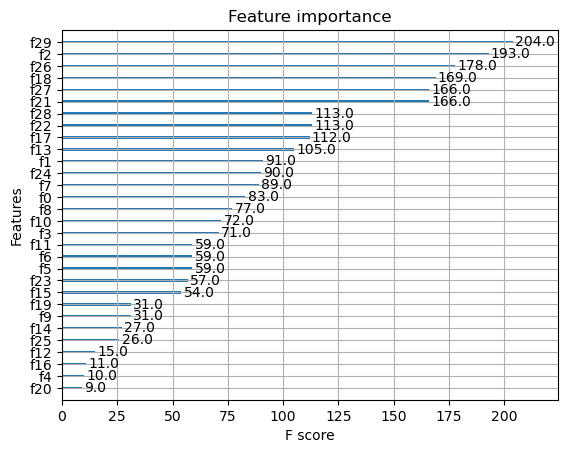

In [170]:
xgb.plot_importance(xgb2)

In [178]:
# XGB Classifier 3 (same as previous but with top 10 features only)

X = friday_1976[['TermSpread','CORESTICKM159SFRBATL', 'PSAVERT', 'ICSA','UNRATE','M2V','^GSPC','MORTGAGE30US',
                'GFDEGDQ188S','DTB3']]

y = friday_1976['DGS10_change_class']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)

xgb3 = XGBClassifier(n_estimators=10000,n_jobs=-1,max_depth=5,learning_rate=0.1,random_state=42,
                    min_child_weight=20, min_split_loss=0.3, reg_alpha=2, reg_lambda=2)
xgb3.fit(X_train,y_train)

train_accuracy = xgb3.score(X_train,y_train)
test_accuracy = xgb3.score(X_test, y_test)
print(f"Train Accuracy: {train_accuracy:.2f}")
print(f"Test Accuracy: {test_accuracy:.2f}")

y_pred_train = xgb3.predict(X_train)
y_pred_test = xgb3.predict(X_test)
print(classification_report(y_train, y_pred_train))
print(classification_report(y_test, y_pred_test))

Train Accuracy: 0.84
Test Accuracy: 0.79
              precision    recall  f1-score   support

           0       0.90      0.63      0.74       354
           1       0.82      0.97      0.89      1317
           2       0.92      0.55      0.69       319

    accuracy                           0.84      1990
   macro avg       0.88      0.72      0.77      1990
weighted avg       0.85      0.84      0.83      1990

              precision    recall  f1-score   support

           0       0.87      0.47      0.61        88
           1       0.78      0.96      0.86       330
           2       0.83      0.44      0.57        80

    accuracy                           0.79       498
   macro avg       0.83      0.62      0.68       498
weighted avg       0.80      0.79      0.77       498



In [187]:
# XGB Classifier 4

X = friday_1976[['TermSpread','CORESTICKM159SFRBATL', 'PSAVERT', 'ICSA','UNRATE','M2V','^GSPC','MORTGAGE30US',
                'GFDEGDQ188S','DTB3']]

y = friday_1976['DGS10_change_class']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)

xgb4 = XGBClassifier(n_estimators=10000,n_jobs=-1,max_depth=6,learning_rate=0.1,random_state=42,
                    min_child_weight=20, min_split_loss=0.5, reg_alpha=5, reg_lambda=0,
                    subsample=0.8, colsample_bytree=0.8)
xgb4.fit(X_train,y_train)

train_accuracy = xgb4.score(X_train,y_train)
test_accuracy = xgb4.score(X_test, y_test)
print(f"Train Accuracy: {train_accuracy:.2f}")
print(f"Test Accuracy: {test_accuracy:.2f}")

y_pred_train = xgb4.predict(X_train)
y_pred_test = xgb4.predict(X_test)
print(classification_report(y_train, y_pred_train))
print(classification_report(y_test, y_pred_test))

Train Accuracy: 0.87
Test Accuracy: 0.81
              precision    recall  f1-score   support

           0       0.91      0.67      0.77       354
           1       0.86      0.97      0.91      1317
           2       0.90      0.68      0.78       319

    accuracy                           0.87      1990
   macro avg       0.89      0.77      0.82      1990
weighted avg       0.87      0.87      0.86      1990

              precision    recall  f1-score   support

           0       0.84      0.52      0.64        88
           1       0.80      0.95      0.87       330
           2       0.83      0.55      0.66        80

    accuracy                           0.81       498
   macro avg       0.82      0.67      0.72       498
weighted avg       0.81      0.81      0.80       498



In [192]:
# XGB Classifier Grid Search 1 (all features)

X = friday_1976.drop(['DGS10_13WShift','^GSPC_13WShift','DGS10_13WChange','^GSPC_13WChange',
                      'DGS10_change_range','DGS10_change_class'],axis=1)

y = friday_1976['DGS10_change_class']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)

xgb_gs1 = XGBClassifier(n_estimators=1000,learning_rate=0.1,random_state=42)

param_test1 = {'max_depth': [5,6,7],
              'gamma': [0.1,0.2,0.3,0.4,0.5],
              'subsample':[0.8,0.9],
              'colsample_bytree': [0.8,0.9],
              'reg_alpha': [0.3, 1, 2, 3],
              'reg_lambda': [0.3, 1, 2, 3]}


grid_search1 = GridSearchCV(xgb_gs1,param_test1,n_jobs=-1,cv=5,scoring='accuracy')

grid_search1.fit(X_train,y_train)

grid_search1_best = grid_search1.best_estimator_

train_accuracy = grid_search1_best.score(X_train,y_train)
test_accuracy = grid_search1_best.score(X_test, y_test)
print(f"Train Accuracy: {train_accuracy:.2f}")
print(f"Test Accuracy: {test_accuracy:.2f}")

y_pred_train = grid_search1_best.predict(X_train)
y_pred_test = grid_search1_best.predict(X_test)
print(classification_report(y_train, y_pred_train))
print(classification_report(y_test, y_pred_test))

print(grid_search1.best_params_)

Train Accuracy: 0.99
Test Accuracy: 0.86
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       354
           1       0.99      1.00      1.00      1317
           2       1.00      0.98      0.99       319

    accuracy                           0.99      1990
   macro avg       1.00      0.99      0.99      1990
weighted avg       0.99      0.99      0.99      1990

              precision    recall  f1-score   support

           0       0.80      0.78      0.79        88
           1       0.88      0.92      0.90       330
           2       0.84      0.72      0.78        80

    accuracy                           0.86       498
   macro avg       0.84      0.81      0.82       498
weighted avg       0.86      0.86      0.86       498

{'colsample_bytree': 0.9, 'gamma': 0.1, 'max_depth': 7, 'reg_alpha': 1, 'reg_lambda': 0.3, 'subsample': 0.9}


In [196]:
# XGB Classifier Grid Search 2 (all features)

X = friday_1976.drop(['DGS10_13WShift','^GSPC_13WShift','DGS10_13WChange','^GSPC_13WChange',
                      'DGS10_change_range','DGS10_change_class'],axis=1)

y = friday_1976['DGS10_change_class']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)

xgb_gs2 = XGBClassifier(n_estimators=1000,learning_rate=0.1,random_state=42)

param_test2 = {'max_depth': [5,6],
              'gamma': [0.3,0.4,0.5],
               'min_child_weight': [20,30,40,50],
              'subsample':[0.8],
              'colsample_bytree': [0.8],
              'reg_alpha': [3,5],
              'reg_lambda': [3,5]}


grid_search2 = GridSearchCV(xgb_gs2,param_test2,n_jobs=-1,cv=5,scoring='accuracy')

grid_search2.fit(X_train,y_train)

grid_search2_best = grid_search2.best_estimator_

train_accuracy = grid_search2_best.score(X_train,y_train)
test_accuracy = grid_search2_best.score(X_test, y_test)
print(f"Train Accuracy: {train_accuracy:.2f}")
print(f"Test Accuracy: {test_accuracy:.2f}")

y_pred_train = grid_search2_best.predict(X_train)
y_pred_test = grid_search2_best.predict(X_test)
print(classification_report(y_train, y_pred_train))
print(classification_report(y_test, y_pred_test))

print(grid_search2.best_params_)

Train Accuracy: 0.92
Test Accuracy: 0.84
              precision    recall  f1-score   support

           0       0.93      0.82      0.87       354
           1       0.92      0.97      0.94      1317
           2       0.94      0.84      0.89       319

    accuracy                           0.92      1990
   macro avg       0.93      0.88      0.90      1990
weighted avg       0.92      0.92      0.92      1990

              precision    recall  f1-score   support

           0       0.85      0.60      0.71        88
           1       0.84      0.94      0.89       330
           2       0.83      0.69      0.75        80

    accuracy                           0.84       498
   macro avg       0.84      0.74      0.78       498
weighted avg       0.84      0.84      0.83       498

{'colsample_bytree': 0.8, 'gamma': 0.3, 'max_depth': 6, 'min_child_weight': 20, 'reg_alpha': 3, 'reg_lambda': 3, 'subsample': 0.8}


In [199]:
# XGB Classifier Grid Search 3 (all features)

X = friday_1976.drop(['DGS10_13WShift','^GSPC_13WShift','DGS10_13WChange','^GSPC_13WChange',
                      'DGS10_change_range','DGS10_change_class'],axis=1)

y = friday_1976['DGS10_change_class']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)

xgb_gs3 = XGBClassifier(n_estimators=1000,learning_rate=0.1,random_state=42)

param_test3 = {'max_depth': [5,6],
              'gamma': [0.4,0.5],
               'min_child_weight': [30,40,50],
              'subsample':[0.8],
              'colsample_bytree': [0.8],
              'reg_alpha': [5,7],
              'reg_lambda': [5,7]}


grid_search3 = GridSearchCV(xgb_gs3,param_test3,n_jobs=-1,cv=5,scoring='accuracy')

grid_search3.fit(X_train,y_train)

grid_search3_best = grid_search3.best_estimator_

train_accuracy = grid_search3_best.score(X_train,y_train)
test_accuracy = grid_search3_best.score(X_test, y_test)
print(f"Train Accuracy: {train_accuracy:.2f}")
print(f"Test Accuracy: {test_accuracy:.2f}")

y_pred_train = grid_search3_best.predict(X_train)
y_pred_test = grid_search3_best.predict(X_test)
print(classification_report(y_train, y_pred_train))
print(classification_report(y_test, y_pred_test))

print(grid_search3.best_params_)

Train Accuracy: 0.85
Test Accuracy: 0.81
              precision    recall  f1-score   support

           0       0.91      0.64      0.75       354
           1       0.84      0.97      0.90      1317
           2       0.89      0.63      0.74       319

    accuracy                           0.85      1990
   macro avg       0.88      0.74      0.79      1990
weighted avg       0.86      0.85      0.85      1990

              precision    recall  f1-score   support

           0       0.88      0.48      0.62        88
           1       0.79      0.96      0.87       330
           2       0.84      0.51      0.64        80

    accuracy                           0.81       498
   macro avg       0.83      0.65      0.71       498
weighted avg       0.81      0.81      0.79       498

{'colsample_bytree': 0.8, 'gamma': 0.4, 'max_depth': 6, 'min_child_weight': 30, 'reg_alpha': 5, 'reg_lambda': 5, 'subsample': 0.8}


### Using more aggressive regularization and limited max depth per tree is leading to less overfitting. The next steps are to use Grid Search on the other types of tree classifiers, as well as to try to limit the models to the top features.